In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import itertools
import tqdm

import time
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

from IPython.display import display, clear_output

In [2]:
# Import the dataset from the .mat file
import scipy.io

dataset_mat = scipy.io.loadmat('MNIST.mat')

In [3]:
# Convert the dataset in numpy
digits = copy.deepcopy(dataset_mat['input_images'])
labels = copy.deepcopy(dataset_mat['output_labels'].squeeze(1))

for i, img in enumerate(digits):
    temp = np.reshape(digits[i], (28, 28)).T
    digits[i] = np.reshape(temp, (784))
    
dataset = list(zip(digits, labels))

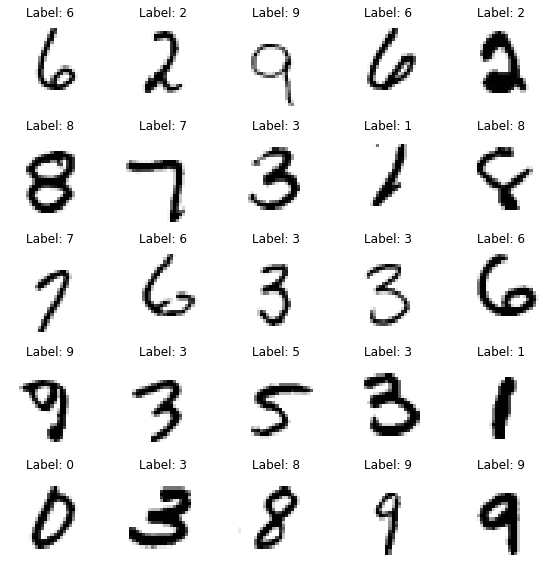

In [4]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, lab = random.choice(dataset)
    ax.imshow(img.reshape(28,28), cmap='gray_r')
    ax.set_title('Label: %d' % lab)
    ax.axis('off')
plt.tight_layout()
plt.savefig('digits.pdf', dpi = 300)
plt.show()

In [5]:
def create_loader(dataset, batch_loader):
    data, labels = zip(*dataset)

    # Convert to torch
    data = torch.tensor(data).float().view(-1, len(data), 28, 28).squeeze(0)
    data = data[:, None, :, :]
    labels = torch.tensor(labels).long().view(-1, len(labels)).squeeze(0)
    dataset_torch = torch.utils.data.TensorDataset(data, labels.squeeze(0))

    return DataLoader(dataset_torch, batch_size=batch_loader, shuffle = True)

In [6]:
def split_dataset(dataset, split):
    random.shuffle(dataset)
    datatrain = dataset[0:split[0]]
    dataval = dataset[split[0]:split[1]]
    datatest = dataset[split[1]:split[2]]
    
    return datatrain, dataval, datatest

In [58]:
def add_noise(img, sigma, prob = 0.8):
    rand_numbers = np.random.rand(len(img))
    noised_img = copy.deepcopy(img)

    for i in range(len(img)):
        if rand_numbers[i] < prob:
            noise = sigma * torch.randn(*img[i].shape)
            noised_img[i] = np.clip(noised_img[i] + noise, 0., 1.)
    return noised_img

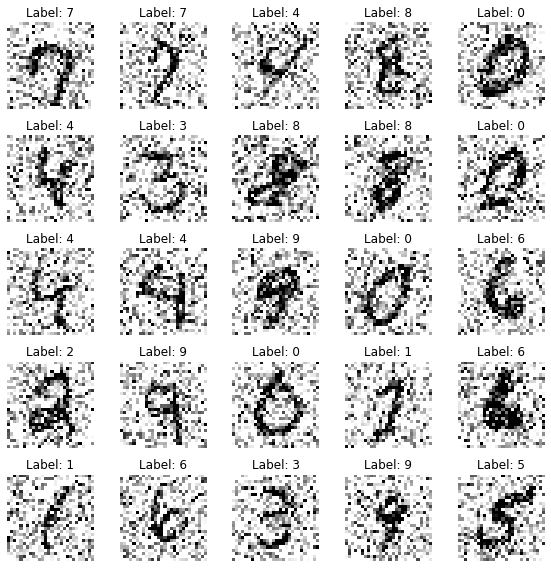

In [43]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, lab = random.choice(dataset)
    noise = sigma * np.random.randn(784)
    noised_img = np.clip(img + noise, 0., 1.)
    
    ax.imshow(noised_img.reshape(28,28), cmap='gray_r')
    ax.set_title('Label: %d' % lab)
    ax.axis('off')
plt.tight_layout()
plt.savefig('digits_noised.pdf', dpi = 300)
plt.show()

In [59]:
split = [40000, 50000, 60000]
data = split_dataset(dataset, split)

batch = [256, 10000, 10000]

trainset = copy.deepcopy(data[0])
valset = copy.deepcopy(data[1])
testset = copy.deepcopy(data[2])

trainloader = create_loader(trainset, batch[0])
valloader = create_loader(valset, batch[1])
testloader = create_loader(testset, batch[2])

In [60]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [61]:
def train_epoch(net, dataloader, loss_fn, optimizer, sigma, noising = True):
    net.train()
    avg_loss = 0
    
    for img_batch, lab_batch in dataloader:
        if noising:
            noised_img_batch = add_noise(img_batch, sigma)
        noised_img_batch = noised_img_batch.to(device)
        
        output = net(noised_img_batch)
                
        # Loss between the output and the original images
        loss = loss_fn(output, img_batch.to(device))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        avg_loss += loss.data
        
    return avg_loss/len(dataloader)

def test_epoch(net, dataloader, loss_fn):
    net.eval()
    avg_loss = 0
    
    with torch.no_grad():
        for img_batch, lab_batch in dataloader:
            img_batch = img_batch.to(device)
            output = net(img_batch)
            
            # The validation loss instead does not see noisy images
            loss = loss_fn(output, img_batch)
            avg_loss += loss.data            
        
    return avg_loss/len(dataloader)

In [62]:
def train_model(net, epochs, trainloader, valloader, loss_fn, optim, sigma):
    train_loss_log = []
    val_loss_log = []
        
    # Pick the best model
    best_val_loss = 10000 
    t0 = time.time()
    for num_epoch in range(epochs):
        time_start = time.time()
        
        train_loss = train_epoch(net, dataloader=trainloader, loss_fn=loss_fn, optimizer=optim, sigma = sigma)
        train_loss_log.append(train_loss)
        
        val_loss = test_epoch(net, dataloader=valloader, loss_fn=loss_fn)
        val_loss_log.append(val_loss)

        time_end = time.time()
        time_epoch = (time_end-time_start)/60
        eta = time_epoch*(epochs-num_epoch)
        
        print('Epoch', num_epoch + 1)
        print('[' + '#'*(100-int(100*(1 -num_epoch/epochs))) + ' '*int(100*(1 - num_epoch/epochs)) + ']')
        print('\t Training loss: ' + f'{train_loss:.5f}')
        print('\t Validation loss: ' + f'{val_loss:.5f}')
        print('\t %4.2f minutes left' % (eta))
        print('\t Elaps: %4.2f minutes' % ((time.time()-t0)/60))
        clear_output(wait = True)
        
        if val_loss < best_val_loss:
            best_model = net
            best_val_loss = val_loss
            best_train_loss = train_loss
            epoch_stop = num_epoch
            #print('Best model!')
        #print('\n')
        
    return best_model, train_loss_log, val_loss_log, epoch_stop

In [63]:
def plot_rec(net, img, filename):
    net.eval()
    with torch.no_grad():
        rec_img  = net(img)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[1].set_title('Reconstructed image')
    axs[0].axis('off')
    axs[1].axis('off')

    plt.tight_layout()
    plt.pause(0.1)
    fig.savefig(filename, dpi = 300)
    plt.show()

In [64]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Selected device:', device)

num_epochs = 150

Selected device: cuda


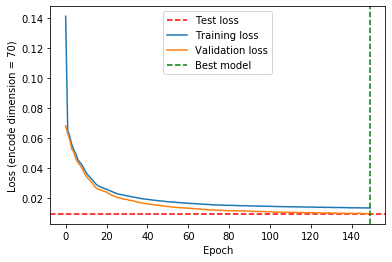

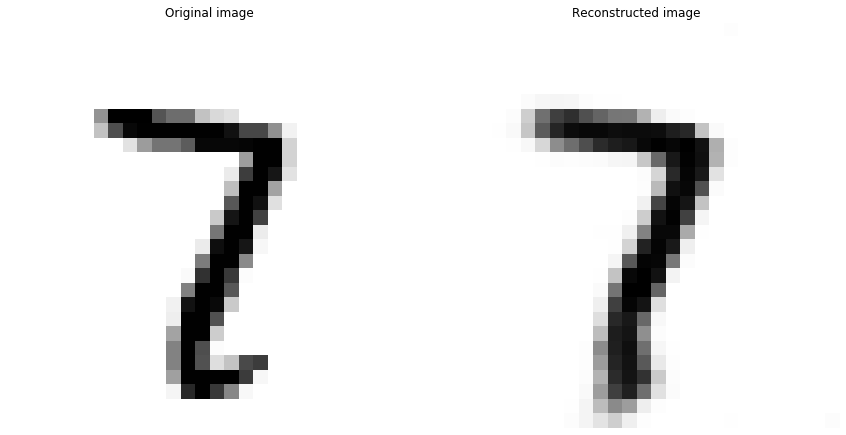

In [65]:
tvet_list = []
encode_dim_list = [2,6,8,10,15,20, 30, 50, 70]


sigma = 0.5

for encode_dim in encode_dim_list:
    ### Init
    net = Autoencoder(encoded_space_dim=encode_dim)
    loss_fn = torch.nn.MSELoss()
    lr = 1e-3
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    
    net.to(device)
    
    ### Training
    net, tll, vll, estop = train_model(net, num_epochs, trainloader, valloader, loss_fn, optim, sigma)
    test_loss = test_epoch(net, dataloader=testloader, loss_fn=loss_fn)
    
    ### Saving
    torch.save(net.state_dict(), 'nets/conv_autoencoder_' + str(encode_dim) +'.torch')
    tvet_list.append(tll)
    tvet_list.append(vll)
    tvet_list.append(estop)
    tvet_list.append(test_loss)    
    
    ### Plots
    plt.axhline(float(test_loss), color = 'red', label = 'Test loss', linestyle = '--')
    plt.plot(tll, label = 'Training loss')
    plt.plot(vll, label = 'Validation loss')
    plt.axvline(x = estop, color ='g', linestyle='--', label = 'Best model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (encode dimension = ' + str(encode_dim) + ')')
    
    plt.legend()
    plt.savefig('loss_' + str(encode_dim) + '.pdf', dpi = 300)
    
    idx = np.random.randint(len(testset))
    img = torch.tensor(testset[idx][0].reshape(28,28))
    img = img[None, None, :, :].to(device)
    
    plot_rec(net, img, 'rec_' + str(encode_dim) + '.pdf')

In [66]:
np.save('tvet_list.npy', tvet_list, allow_pickle = True)
np.save('testset', testset, allow_pickle = True)